In [82]:
import matplotlib.pyplot as plt
from gym_anytrading.envs import StocksEnv
from finta import TA
import random
import tensorflow as tf
import numpy as np
import pandas as pd
random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [83]:
tickers_negro = [
    ("NVDA", "2012-01-01", "2023-12-31"),
    ("INTC", "2012-01-01", "2023-12-31"),
    ("FRT", "2012-01-01", "2023-12-31"),
    ("NKE", "2012-01-01", "2023-12-31"),
    ("TSM", "2012-01-01", "2023-12-31"),
    ("USB", "2012-01-01", "2023-12-31"),
    ("XOM", "2012-01-01", "2023-12-31"),
    ("BA", "2012-01-01", "2023-12-31"),
    ("NEM", "2012-01-01", "2023-12-31"),
    ("HBAN", "2012-01-01", "2023-12-31"),

    ("VZ", "2012-01-01", "2023-12-31"),
    ("PCG", "2012-01-01", "2023-12-31"),
    ("FCX", "2012-01-01", "2023-12-31"),
    ("C", "2012-01-01", "2023-12-31"),
    ("OXY", "2012-01-01", "2023-12-31"),
    ("KEY", "2012-01-01", "2023-12-31"),
    ("WFC", "2012-01-01", "2023-12-31"),
    ("MRO", "2012-01-01", "2023-12-31"),
    ("GOOGL", "2012-01-01", "2023-12-31"),
    ("NFLX", "2012-01-01", "2023-12-31"),

    ("HDB", "2012-01-01", "2023-12-31"),
    ("MU", "2012-01-01", "2023-12-31"),
    ("AVY", "2012-01-01", "2023-12-31"),
    ("MET", "2012-01-01", "2023-12-31"),
    ("MSTR", "2012-01-01", "2023-12-31"),
    ("WMB", "2012-01-01", "2023-12-31"),
    ("BSX", "2012-01-01", "2023-12-31"),
    ("EBAY", "2012-01-01", "2023-12-31"),
    ("SO", "2012-01-01", "2023-12-31"),
    ("CTSH", "2012-01-01", "2023-12-31"),

    ("BBWI", "2012-01-01", "2023-12-31"),
    ("V", "2012-01-01", "2023-12-31"),
    ("VFC", "2012-01-01", "2023-12-31"),
    ("MOS", "2012-01-01", "2023-12-31"),
    ("CRM", "2012-01-01", "2023-12-31"),
    ("SCHW", "2012-01-01", "2023-12-31"),
    ("CNP", "2012-01-01", "2023-12-31"),
    ("MDT", "2012-01-01", "2023-12-31"),
    ("EXC", "2012-01-01", "2023-12-31"),
    ("MTCH", "2012-01-01", "2023-12-31"),

    ("PARA", "2012-01-01", "2023-12-31"),
    ("UAL", "2012-01-01", "2023-12-31"),
    ("JNJ", "2012-01-01", "2023-12-31"),
    ("LUV", "2012-01-01", "2023-12-31"),
    ("MCD", "2012-01-01", "2023-12-31"),
    ("JPM", "2012-01-01", "2023-12-31"),
    ("GILD", "2012-01-01", "2023-12-31"),
    ("CVS", "2012-01-01", "2023-12-31"),
    ("ORCL", "2012-01-01", "2023-12-31"),
    ("UHS", "2012-01-01", "2023-12-31")
]

RSI

In [120]:
import yfinance as yf
import numpy as np

datas = {}

for k,i in enumerate(tickers_negro): 
    datas[i[0]] = yf.download(i[0], start=i[1], end= i[2],interval="1d")

    # prices = np.array(data['Adj Close'].values) #Adj Close prices
    dates = np.array(datas[i[0]].index.values).astype('datetime64[ns]') #Dates
    datas[i[0]]['rsi'] = TA.RSI(datas[i[0]],14,column='adj close') #Relative Strength Index (RSI)
    datas[i[0]]['macd'] = TA.MACD(datas[i[0]],column='adj close')['MACD'] #MACD Line
    datas[i[0]]['macd_signal'] = TA.MACD(datas[i[0]], column='adj close')['SIGNAL'] #MACD Signal Line
    datas[i[0]]['bb_bbm'] = TA.BBANDS(datas[i[0]], column='adj close')['BB_MIDDLE'] #Bollinger Bands (BB) middle band (BBM)
    datas[i[0]]['bb_bbu'] = TA.BBANDS(datas[i[0]], column='adj close')['BB_UPPER'] #Bollinger Bands (BB) upper band (BBU)
    datas[i[0]]['bb_bbl'] = TA.BBANDS(datas[i[0]],column='adj close')['BB_LOWER'] #Bollinger Bands (BB) lower band (BBL)
    datas[i[0]]['bb_width'] = TA.BBWIDTH(datas[i[0]],column='adj close') #Bollinger Bands (BB) width
    datas[i[0]]['obv'] = TA.OBV(datas[i[0]],'adj close') #On Balance Volume (OBV)
    datas[i[0]]['from'] = pd.DataFrame([k] * len(datas[i[0]]))
    
    datas[i[0]].fillna(0, inplace=True)
    datas[i[0]] = datas[i[0]][datas[i[0]].index > '2013-01-01']
    datas[i[0]]
    
df= pd.concat([df for df in datas.values()], axis=0)
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Open,High,Low,Close,Adj Close,Volume,rsi,macd,macd_signal,bb_bbm,bb_bbu,bb_bbl,bb_width,obv,from
Date,,,,,,,,,,,,,,,
2013-01-02,3.140000,3.182500,3.127500,3.180000,2.935840,47883600,60.223842,0.011304,0.011125,3.089000,3.206539,2.971461,0.076101,-390527600.0,0.0
2013-01-03,3.180000,3.217500,3.145000,3.182500,2.938149,29888800,60.423426,0.017204,0.012340,3.096875,3.216985,2.976765,0.077569,-360638800.0,0.0
2013-01-04,3.187500,3.297500,3.177500,3.287500,3.035086,52496800,67.742551,0.029362,0.015745,3.111750,3.246298,2.977202,0.086478,-308142000.0,0.0
2013-01-07,3.285000,3.295000,3.170000,3.192500,2.947381,61073200,57.399527,0.031557,0.018907,3.121625,3.249990,2.993260,0.082242,-369215200.0,0.0
2013-01-08,3.200000,3.210000,3.100000,3.122500,2.882756,46642400,51.196676,0.027762,0.020678,3.128250,3.243191,3.013309,0.073486,-415857600.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,151.500000,153.570007,151.250000,153.080002,152.890701,382700,71.002013,5.003540,4.321617,142.904999,156.466951,129.343047,0.189804,71061900.0,0.0
2023-12-26,153.279999,155.179993,152.630005,154.130005,153.939407,288000,72.122511,5.169724,4.491238,143.749999,157.901990,129.598008,0.196897,71349900.0,0.0
2023-12-27,153.929993,153.949997,151.699997,152.610001,152.421280,374400,68.024727,5.119908,4.616972,144.576499,158.752434,130.400564,0.196103,70975500.0,0.0


In [174]:
data = yf.download('GOOG', start='2012-01-01', end='2023-12-31' ,interval="1d")
prices = np.array(data['Adj Close'].values) #Adj Close prices


dates = np.array(data.index.values).astype('datetime64[ns]') #Dates
data['rsi'] = TA.RSI(data,14,column='adj close') #Relative Strength Index (RSI)
data['macd'] = TA.MACD(data,column='adj close')['MACD'] #MACD Line
data['macd_signal'] = TA.MACD(data, column='adj close')['SIGNAL'] #MACD Signal Line
data['bb_bbm'] = TA.BBANDS(data, column='adj close')['BB_MIDDLE'] #Bollinger Bands (BB) middle band (BBM)
data['bb_bbu'] = TA.BBANDS(data, column='adj close')['BB_UPPER'] #Bollinger Bands (BB) upper band (BBU)
data['bb_bbl'] = TA.BBANDS(data,column='adj close')['BB_LOWER'] #Bollinger Bands (BB) lower band (BBL)
data['bb_width'] = TA.BBWIDTH(data,column='adj close') #Bollinger Bands (BB) width
data['obv'] = TA.OBV(data,'adj close') #On Balance Volume (OBV)

data.fillna(0, inplace=True)
data = data[data.index > '2013-01-01']
data



[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,rsi,macd,macd_signal,bb_bbm,bb_bbu,bb_bbl,bb_width,obv
Date,,,,,,,,,,,,,,
2013-01-02,17.918339,18.107130,17.846855,18.013729,18.013729,102033017,63.613447,0.175738,0.174752,17.551662,18.196378,16.906946,0.073465,7.949284e+07
2013-01-03,18.055573,18.229919,17.950716,18.024191,18.024191,93075567,63.806858,0.191381,0.178078,17.592310,18.249053,16.935567,0.074663,1.725684e+08
2013-01-04,18.165413,18.467529,18.124067,18.380356,18.380356,110954331,69.709819,0.229868,0.188436,17.654763,18.362494,16.947032,0.080175,2.835227e+08
2013-01-07,18.317591,18.415474,18.196297,18.300158,18.300158,66476239,67.057712,0.251004,0.200950,17.709085,18.440659,16.977510,0.082621,2.170465e+08
2013-01-08,18.319834,18.338762,18.043119,18.264042,18.264042,67295297,65.842868,0.261822,0.213124,17.770218,18.470534,17.069902,0.078819,1.497512e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,142.130005,143.250000,142.054993,142.720001,142.720001,18494700,64.953258,1.421675,0.575959,135.933500,142.641226,129.225774,0.098691,3.439367e+09
2023-12-26,142.979996,143.945007,142.500000,142.820007,142.820007,11170100,65.115855,1.718241,0.804416,136.172000,143.506508,128.837492,0.107724,3.450537e+09
2023-12-27,142.830002,143.320007,141.050995,141.440002,141.440002,17288400,60.916000,1.820926,1.007718,136.313000,143.947932,128.678069,0.112021,3.433249e+09


## Enviroment

In [175]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Adj Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:,['rsi','Volume','macd','macd_signal','bb_bbm','bb_bbu','bb_bbl','bb_width','obv']].to_numpy()[start:end]
    return prices, signal_features

# def reward_function(env,action):
#     pass


In [176]:
class customEnv(StocksEnv):
    """
    Custom Environment for RL trading
    """
    _process_data = add_signals

    # _calculate_reward = reward_function
    

train

In [171]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
    
env = customEnv(df=data, window_size=14, frame_bound=(14, 100))
env_maker = lambda: env
env_train = DummyVecEnv([env_maker])
model = A2C('MlpPolicy', env_train, verbose=1)
model.learn(total_timesteps=100000)

Using cuda device
------------------------------------
| time/                 |          |
|    fps                | 405      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | -26.8    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.117   |
|    value_loss         | 0.0443   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 409      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.682   |
|    explained_variance | 0.142    |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -0.083   |
|    value_loss     

In [61]:
model.save('RL_del_gran_pisky_model.h5')

Evaluation

In [191]:
#load model
from stable_baselines3 import A2C
model = A2C.load('RL_del_gran_pisky_model.h5')

In [194]:

data = yf.download('MMM', start='2010-01-01', end= '2024-01-01',interval="1d")
prices = np.array(data['Adj Close'].values) #Adj Close prices
dates = np.array(data.index.values).astype('datetime64[ns]') #Dates
data['rsi'] = TA.RSI(data,14,column='adj close') #Relative Strength Index (RSI)
data['macd'] = TA.MACD(data,column='adj close')['MACD'] #MACD Line
data['macd_signal'] = TA.MACD(data, column='adj close')['SIGNAL'] #MACD Signal Line
data['bb_bbm'] = TA.BBANDS(data, column='adj close')['BB_MIDDLE'] #Bollinger Bands (BB) middle band (BBM)
data['bb_bbu'] = TA.BBANDS(data, column='adj close')['BB_UPPER'] #Bollinger Bands (BB) upper band (BBU)
data['bb_bbl'] = TA.BBANDS(data,column='adj close')['BB_LOWER'] #Bollinger Bands (BB) lower band (BBL)
data['bb_width'] = TA.BBWIDTH(data,column='adj close') #Bollinger Bands (BB) width
data['obv'] = TA.OBV(data,'adj close') #On Balance Volume (OBV)

data.fillna(0, inplace=True)
data = data[data.index > '2013-01-01']
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,rsi,macd,macd_signal,bb_bbm,bb_bbu,bb_bbl,bb_width,obv
Date,,,,,,,,,,,,,,
2013-01-02,78.754181,79.255852,78.561874,79.247490,51.153252,3835213,63.468528,0.415588,0.420258,77.434365,78.699448,76.169281,0.032675,-11451690.0
2013-01-03,78.879601,79.372910,78.704010,79.155518,51.093903,3234702,62.755753,0.457320,0.427671,77.624582,78.814598,76.434565,0.030661,-14686392.0
2013-01-04,79.255852,79.832779,79.046822,79.740807,51.471695,3235060,65.418112,0.514942,0.445125,77.817308,79.033350,76.601265,0.031254,-11451332.0
2013-01-07,79.448158,80.041809,79.230766,79.841141,51.536469,3283977,65.868608,0.559386,0.467977,78.007107,79.231594,76.782620,0.031394,-8167355.0
2013-01-08,79.573578,80.058525,79.515053,79.849495,51.541855,3175978,65.908379,0.588262,0.492034,78.173913,79.419942,76.927884,0.031878,-4991377.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,88.528427,89.807693,88.419731,88.904678,87.167412,2728913,66.754641,2.427033,2.525545,86.084867,91.047006,81.122728,0.115285,144666382.0
2023-12-26,88.879601,90.794312,88.854515,90.392975,88.626625,3332176,70.291901,2.485730,2.517582,86.546405,91.301672,81.791138,0.109889,147998558.0
2023-12-27,90.301003,91.220734,90.033447,90.919731,89.143089,2922785,71.449750,2.544589,2.522984,86.974081,91.686467,82.261694,0.108363,150921343.0


In [195]:
from gym_anytrading.envs import Actions

env_test = customEnv(df=data, window_size=14, frame_bound=(15, 300))
obs,_ = env_test.reset(seed=42)
r= []
action_stats = {Actions.Sell: 0, Actions.Buy: 0}
buy_rsi = []
sell_rsi = []
lt=0
while True:
    actual_lt= env_test._last_trade_tick
    obs = obs[np.newaxis, ...] 
    action, _states = model.predict(obs)
    # print(env_test._last_trade_tick)
    # break
    # print('skipped',action)
    if lt!=actual_lt:
        # print(action,"Last trade tick:",actual_lt)
        lt=actual_lt
        
        # print(action)
    action_stats[Actions(action)] += 1
    if action == 0:
        # print("Sell")
        # sell_rsi.append()
        sell_rsi.append(env_test.signal_features[env_test._last_trade_tick][0])

        pass
    elif action == 1:
        # print("Buy")
        buy_rsi.append(env_test.signal_features[env_test._last_trade_tick][0])
    # else:
        # print('??')
    # print(rewards)
    obs, rewards,_ , done, info= env_test.step(action)

    r.append(rewards)
    if done:
        print("info",info)
        break

info {'total_reward': 13.649158477783203, 'total_profit': 0.5542428077449585, 'position': <Positions.Long: 1>}


OPTUNA

In [134]:
env_test.signal_features[env_test._current_tick] #obtener los valores del dia que se va a predecir

array([5.43242917e+01, 1.21345000e+07, 1.50980314e+00, 2.06492676e+00,
       6.31920715e+01, 6.56383015e+01, 6.07458416e+01, 7.74220538e-02,
       5.14332000e+08])

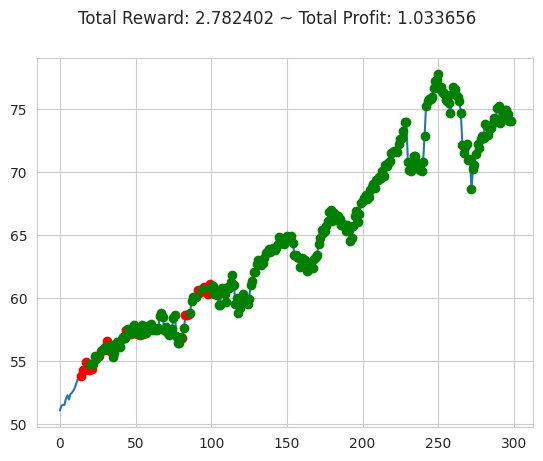

In [166]:
env_test.render_all()

In [136]:
print("env information:")
print("> shape:", env_test.unwrapped.shape)
print("> df.shape:", env_test.unwrapped.df.shape)
print("> prices.shape:", env_test.unwrapped.prices.shape)
print("> signal_features.shape:", env_test.unwrapped.signal_features.shape)
print("> max_possible_profit:", env_test.unwrapped.max_possible_profit())


env information:
> shape: (14, 9)
> df.shape: (2768, 14)
> prices.shape: (299,)
> signal_features.shape: (299, 9)
> max_possible_profit: 41.69065663868925


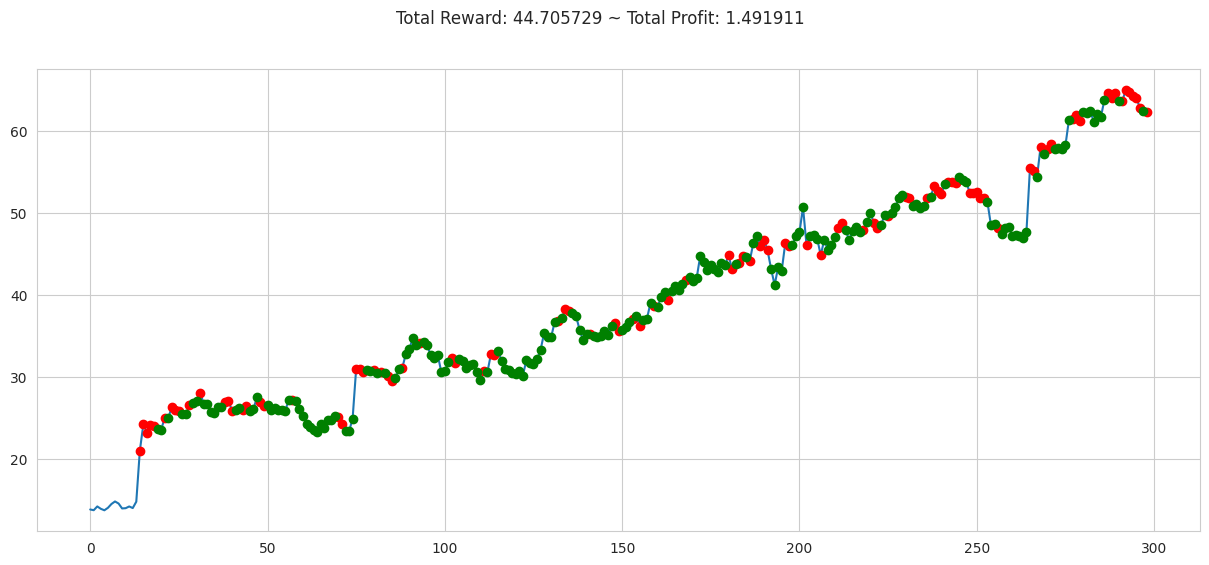

In [137]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.cla()
env_test.render_all()
plt.show()

## ELSE

In [85]:
env_test.step([2])

(array([[42.90572383],
        [41.18560508],
        [45.41570043],
        [44.84428623],
        [41.58389845],
        [50.6287522 ],
        [50.53785334],
        [49.6733183 ],
        [55.72457154],
        [58.62552725],
        [56.61125879],
        [55.63836965],
        [54.90352122],
        [52.71871221]]),
 0,
 False,
 False,
 {'total_reward': 0.0, 'total_profit': 1.0, 'position': <Positions.Short: 0>})

In [3]:

rsi = calculate_rsi(prices)



[*********************100%%**********************]  1 of 1 completed


## Enviroment

# Vengo al tiro igual